# Seisbench (detections the easy way)

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

**Author:** Amanda M. Thomas (modified from Seisbench colab notebook for Ferndale)
**Goal:** A quick Seisbench demonstration.

In [11]:
import seisbench
import seisbench.models as sbm

# Creating a model

#### Here you can download your pretrained model for predicting on the example streams.
if you would like to see the full suite of available pre-trained weights for any model, you can call the ```list_pretrained``` method, which will return all the associated weights for the model, along with information on the training procedure for each set of weights. For the purposes of this plug-in-and-play example, we comment out a number of available models, for you to load and try out.


In [12]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
# pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
eqt_model = sbm.EQTransformer.from_pretrained("original")
# eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
# eqt_model = sbm.EQTransformer.from_pretrained("scedc")
# eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

/Users/amt/anaconda3/envs/pytorch/lib/python3.12/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{path

# Read in waveforms
This waveform example contains part of the 2009 L'Acquila earthquake sequence occuring in the Abruzzo region of central Italy. The Mw 6.4 mainshock is located ~2 minutes into the seismic recording, with many afterhshocks occuring directly after. The seismic trace loaded in from obspy spans the ~1 hour period immediately following the mainshock.

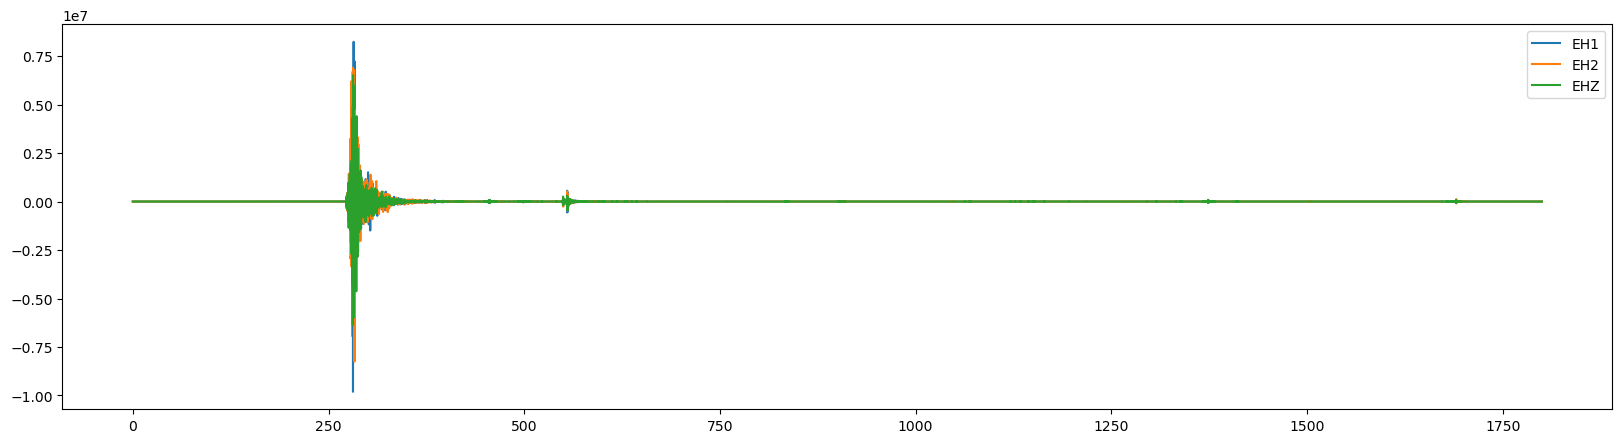

In [13]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

# Load the data
stream = obs.read('../data/B047*')
stream = obs.read('../../../shared/shortcourses/crescent_ml_2025/miniseed/B047*')

# Detrend the data
stream.detrend("linear")

# Trim to earthquake time
stream.trim(starttime=UTCDateTime(2022,12,20,10,30,00),endtime=UTCDateTime(2022,12,20,11,00,00))

# Plot the data
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();

# Predict model on seismic stream

We can apply our varying models now to the seismic stream through the high level ```annotate``` method. This will output the charactersitic functions for the probability of a P-phase, S-phase, and noise class respectively.

In [14]:
pn_preds = pn_model.annotate(stream)
eqt_preds = eqt_model.annotate(stream)
gpd_preds = gpd_model.annotate(stream)

pn_preds

3 Trace(s) in Stream:
PB.B047..PhaseNet_P | 2022-12-20T10:30:02.500000Z - 2022-12-20T10:59:57.500000Z | 100.0 Hz, 179501 samples
PB.B047..PhaseNet_S | 2022-12-20T10:30:02.500000Z - 2022-12-20T10:59:57.500000Z | 100.0 Hz, 179501 samples
PB.B047..PhaseNet_N | 2022-12-20T10:30:02.500000Z - 2022-12-20T10:59:57.500000Z | 100.0 Hz, 179501 samples

## Step through to 'zoom in' on predictions

Enter window length in seconds, and define which model predictions you would like to plot

In [15]:
wlength = 3 * 60 #@param

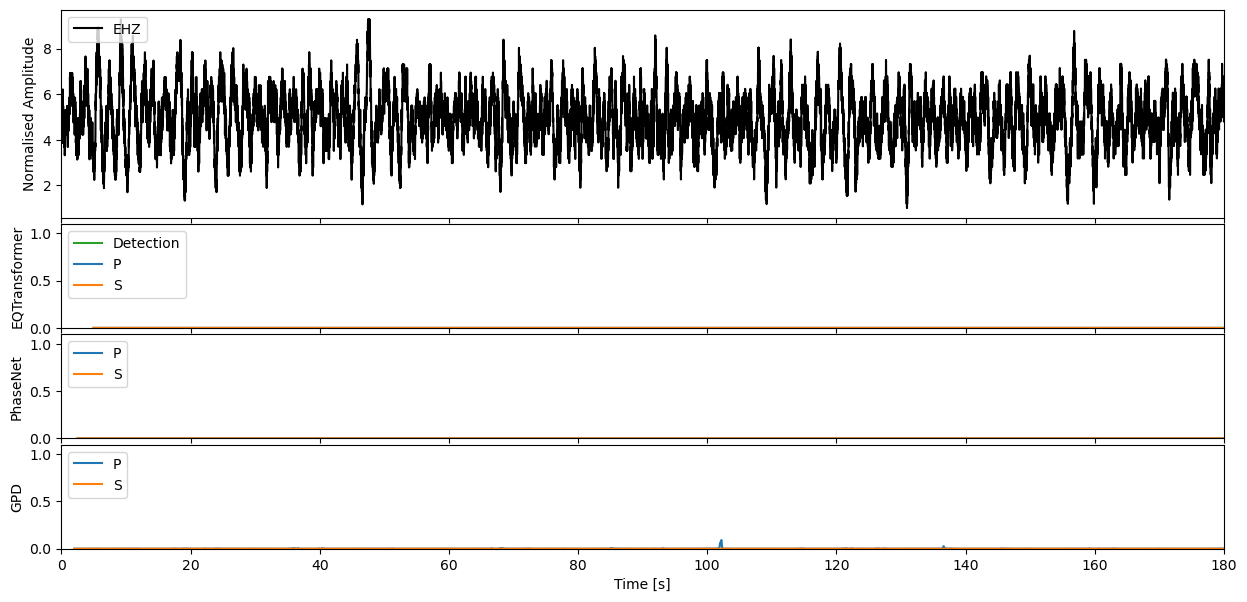

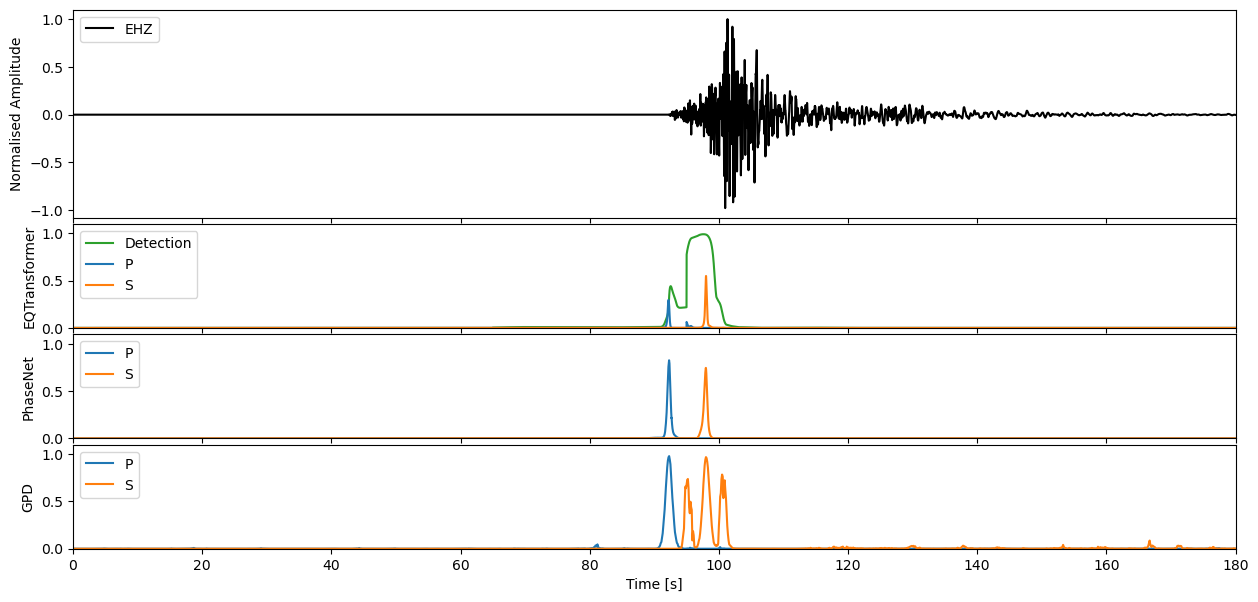

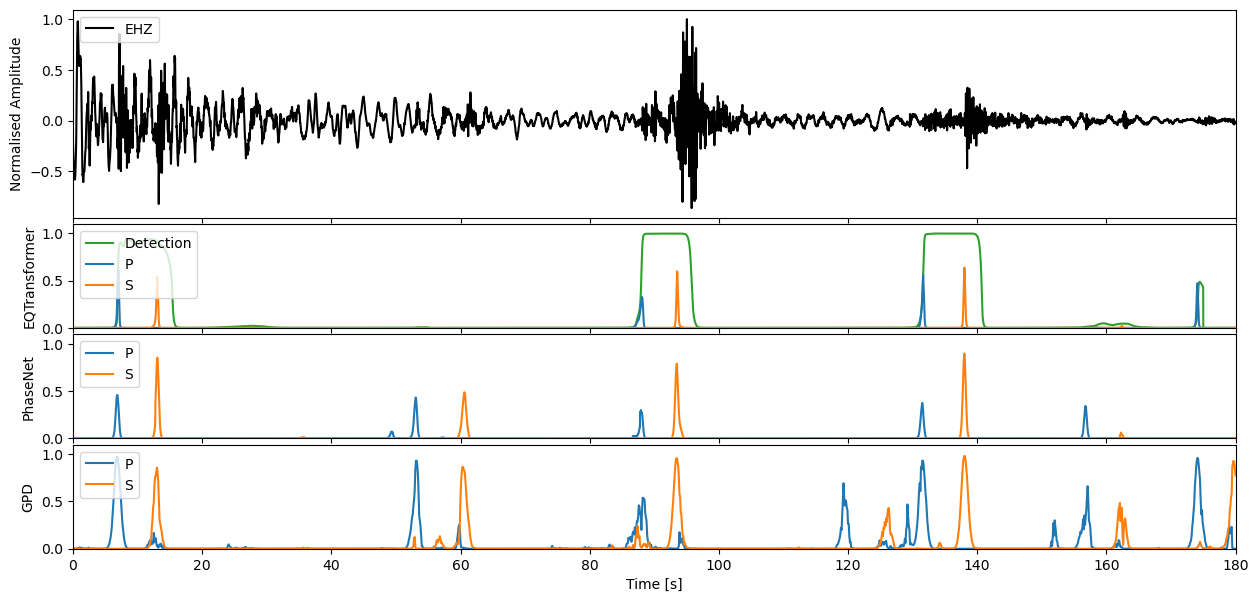

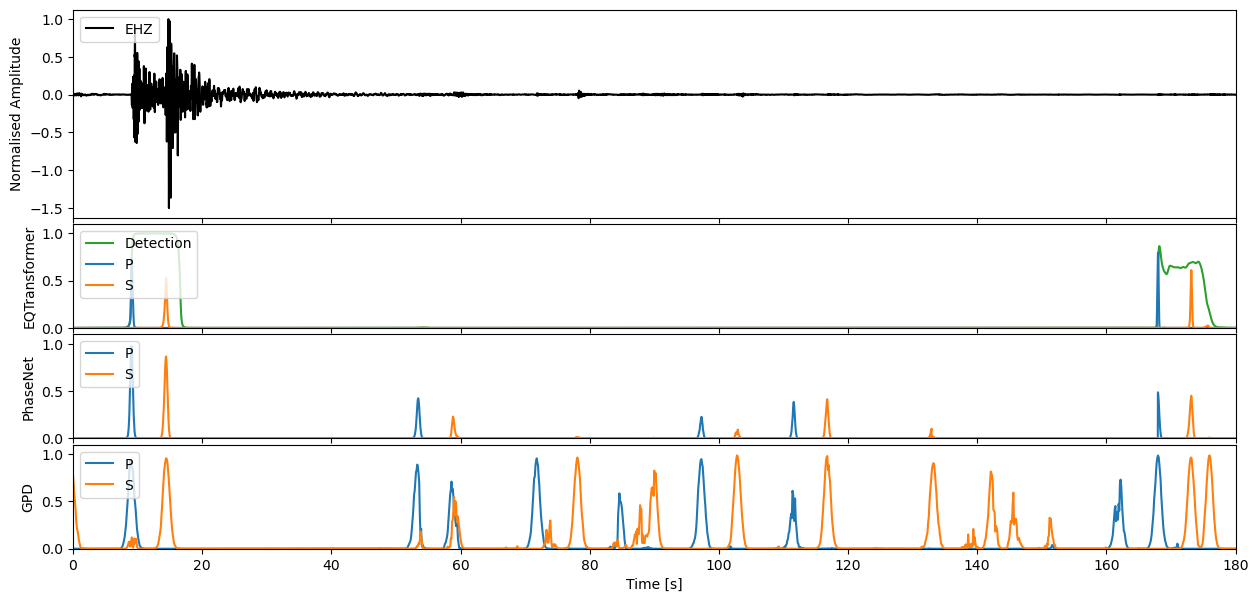

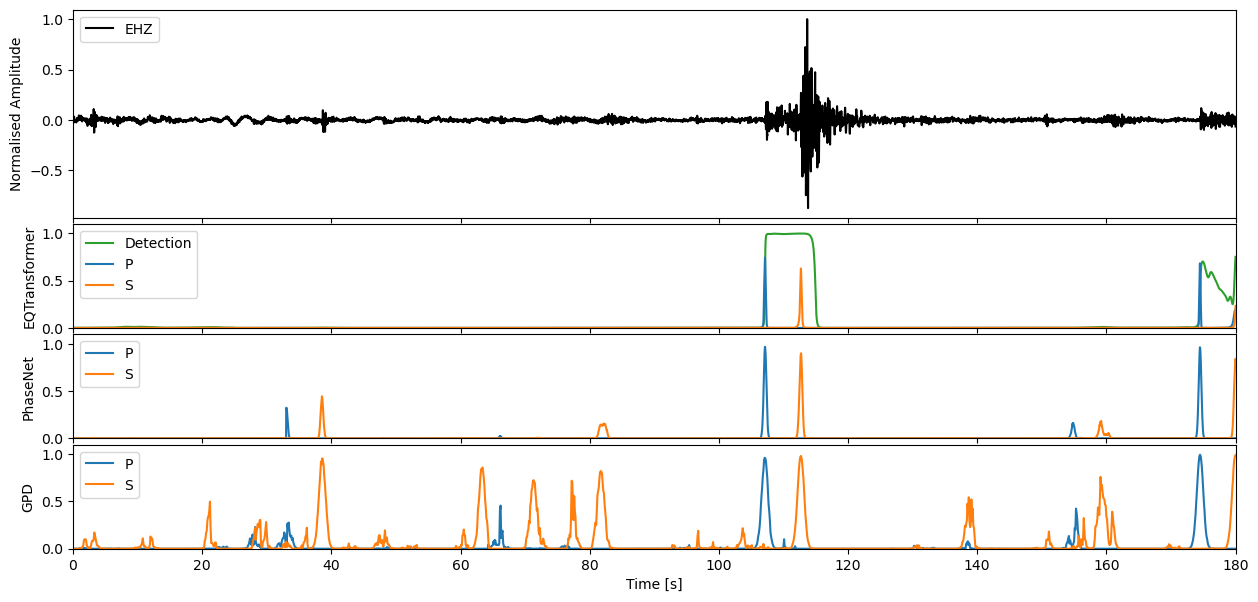

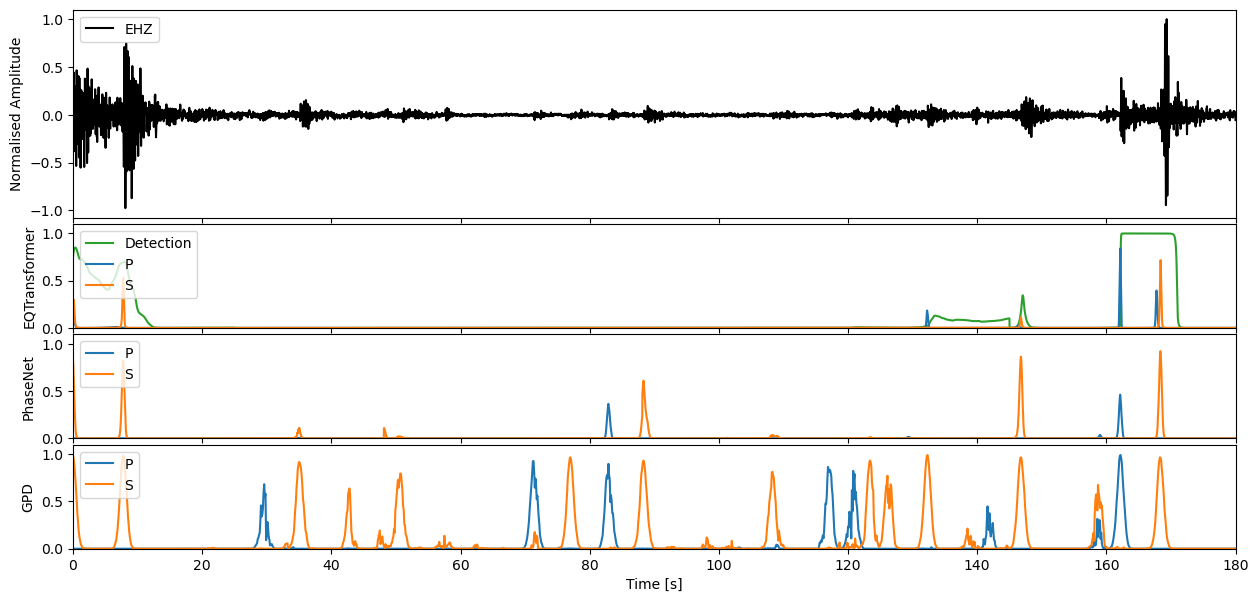

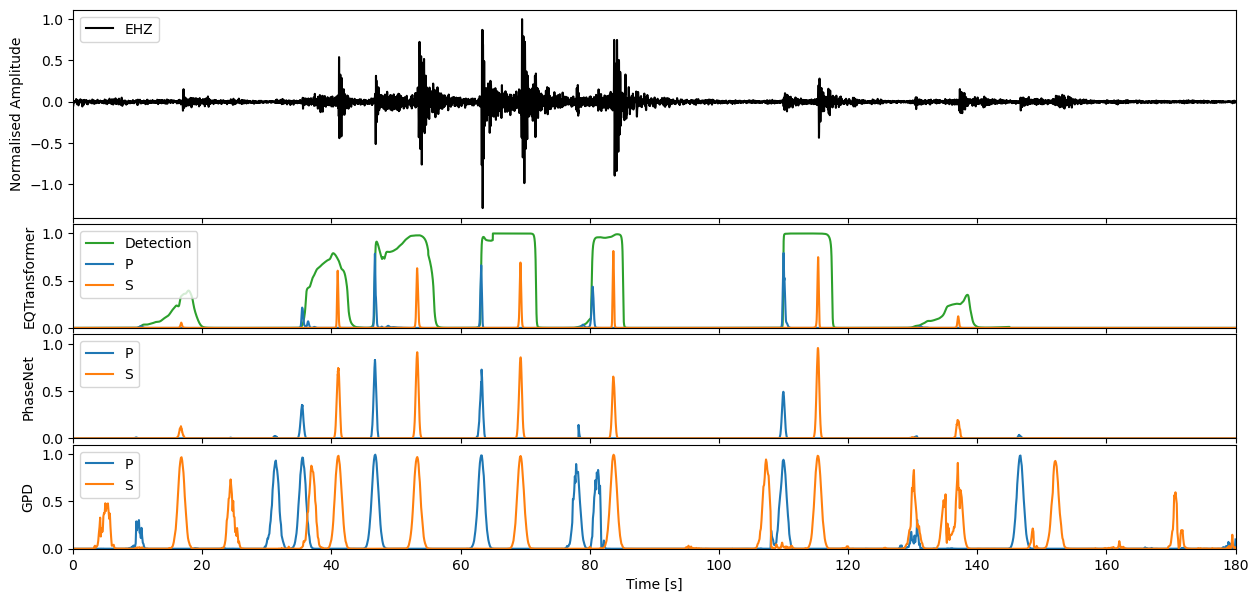

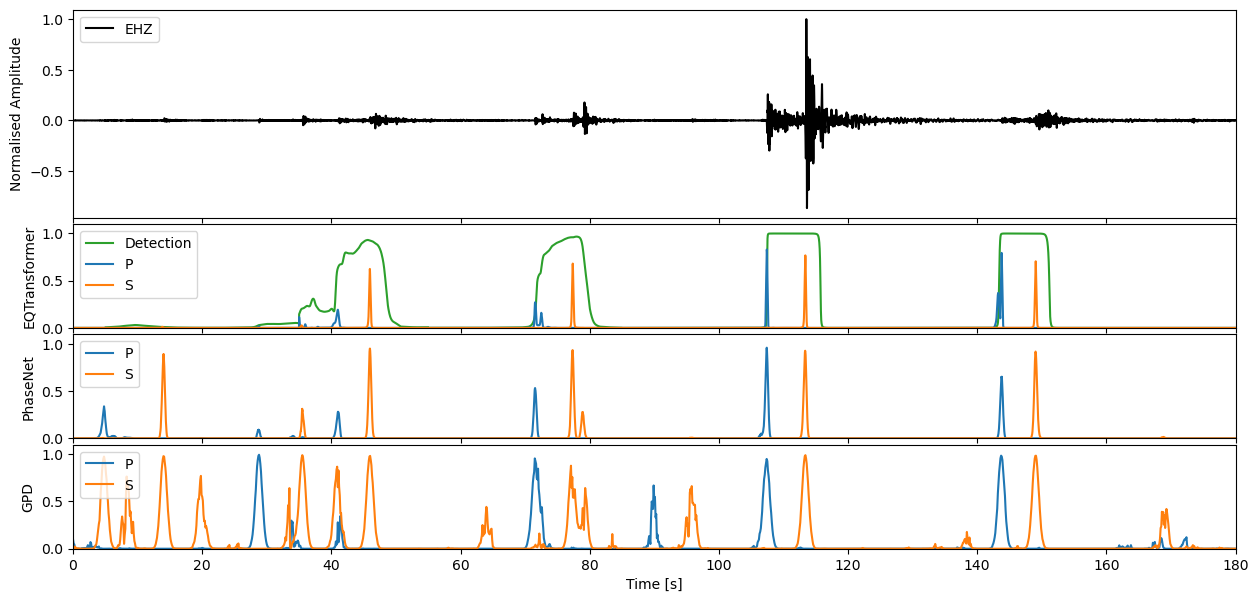

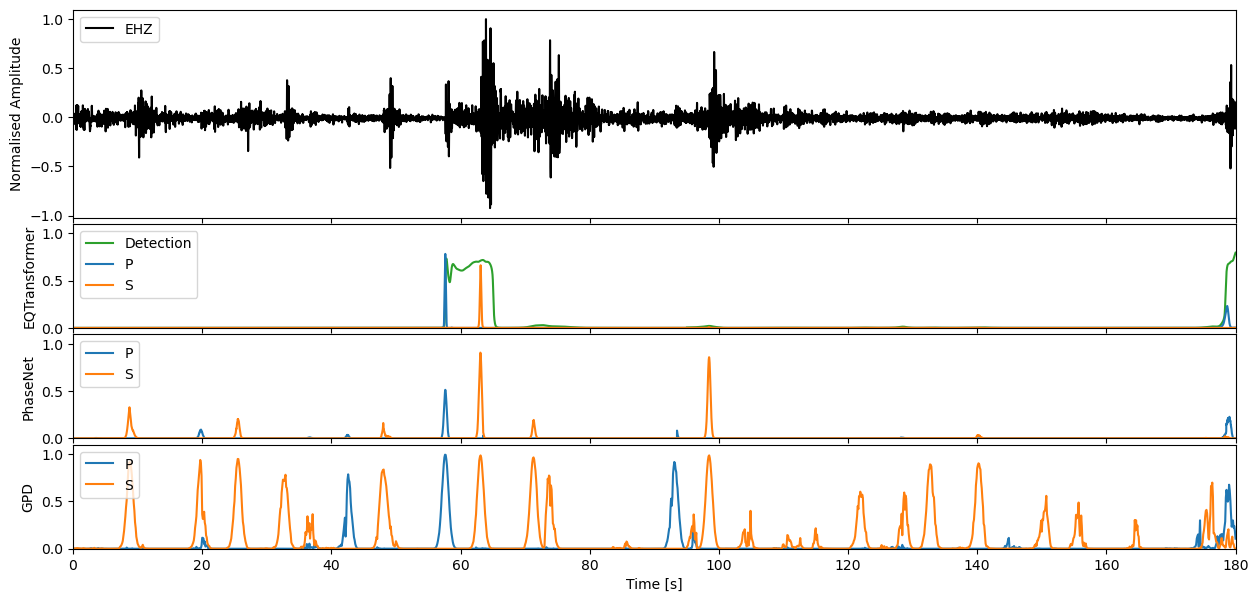

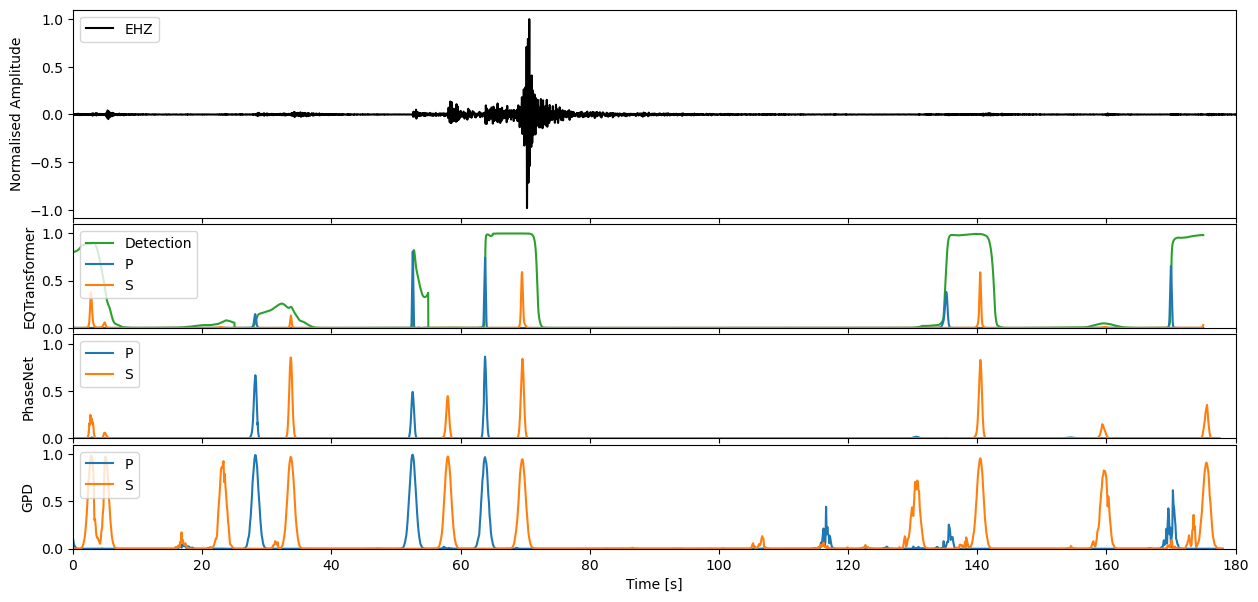

In [16]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}

for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
    t0 = stream[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream.copy().slice(t0, t1)

    fig, ax = plt.subplots(4, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1]})

    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        ax[i + 1].set_ylim(0, 1.1)

    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()

If you would like to then make deterministic detections from the continuous characteristic functions, the ```classify``` method of each model will allow you to perform this task.

In [18]:
outputs = pn_model.classify(stream)

In [19]:
print(outputs)

ClassifyOutput(creator='PhaseNet', picks=PickList with 63 entries:

PB.B047.	2022-12-20T10:34:32.290000Z	P
PB.B047.	2022-12-20T10:34:37.980000Z	S
PB.B047.	2022-12-20T10:36:06.840000Z	P
...
PB.B047.	2022-12-20T10:58:09.580000Z	S
PB.B047.	2022-12-20T10:59:20.490000Z	S
PB.B047.	2022-12-20T10:59:55.580000Z	S)


With each pick storing the following information:

In [37]:
print(outputs.picks[0].__dict__)

{'trace_id': 'PB.B047.', 'start_time': UTCDateTime(2022, 12, 20, 10, 34, 31, 910000), 'end_time': UTCDateTime(2022, 12, 20, 10, 34, 32, 770000), 'peak_time': UTCDateTime(2022, 12, 20, 10, 34, 32, 290000), 'peak_value': 0.82617074, 'phase': 'P'}


In [42]:
stream[0].stats.sampling_rate
print((outputs.picks[ii].__dict__['peak_time']))
print(stream[0].stats.starttime)


2022-12-20T10:34:32.290000Z
2022-12-20T10:29:59.998400Z


In [45]:
import pandas as pd

# Output file
output_file = 'seisbench_detections_%s.%s.%s.%s.csv'%(stream[0].stats.network,stream[0].stats.station,stream[0].stats.starttime.year,stream[0].stats.starttime.julday)

# Reformat output to desired structure
formatted = []
for ii in range(len(outputs.picks)):
    formatted.append({
        'phase': outputs.picks[ii].__dict__['phase'],
        'time': outputs.picks[ii].__dict__['peak_time'],  # Convert UTCDateTime to ISO 8601 string
        'confidence':  outputs.picks[ii].__dict__['peak_value']
    })

# Convert to DataFrame
df = pd.DataFrame(formatted)

# Optional: Save to CSV
df.to_csv(output_file, index=False)

! head seisbench_detections_*.csv

phase,time,confidence
P,2022-12-20T10:34:32.290000Z,0.82617074
S,2022-12-20T10:34:37.980000Z,0.7456388
P,2022-12-20T10:36:06.840000Z,0.45904273
S,2022-12-20T10:36:13.060000Z,0.85334134
P,2022-12-20T10:36:53.070000Z,0.43234748
S,2022-12-20T10:37:00.600000Z,0.48813757
P,2022-12-20T10:37:27.950000Z,0.29602423
S,2022-12-20T10:37:33.480000Z,0.78957117
P,2022-12-20T10:38:11.490000Z,0.37381783
